<a href="https://colab.research.google.com/github/oliveiraprg/text-summarization-with-python/blob/main/algoritimo_de_luhn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sumarização de textos com o Algoritimo de Luhn 



*  [ https://courses.ischool.berkeley.edu/i256/f06/papers/luhn58.pdf](https://courses.ischool.berkeley.edu/i256/f06/papers/luhn58.pdf)




## Preparação do texto de exemplo

In [100]:
import re
import nltk
import numpy
import string
import heapq

In [101]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [102]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [103]:
texto_original = """A inteligência artificial é a inteligência similar à humana máquinas.
                    Definem como o estudo de agente artificial com inteligência.
                    Ciência e engenharia de produzir máquinas com inteligência.
                    Resolver problemas e possuir inteligência. 
                    Relacionada ao comportamento inteligente. 
                    Construção de máquinas para raciocinar. 
                    Aprender com os erros e acertos. 
                    Inteligência artificial é raciocinar nas situações do cotidiano."""

In [104]:
texto_original = re.sub(r'\s+', ' ', texto_original)

In [105]:
stop_words = nltk.corpus.stopwords.words('portuguese')

In [106]:
stop_words.append('ser')
stop_words.append('além')

In [107]:
def pre_processamento(texto):
  texto_formatado = texto.lower()
  tokens = []
  for token in nltk.word_tokenize(texto_formatado):
    tokens.append(token)
  tokens = [palavra for palavra in tokens if palavra not in stop_words and palavra not in string.punctuation]
  texto_formatado = ' '.join([str(elemento) for elemento in tokens if not elemento.isdigit()])
  return texto_formatado

## Função para calcular a nota das sentenças

In [108]:
def calcula_nota_sentenca(sentencas, palavras_importantes, distancia):
  notas = []
  indice_sentenca = 0

  for sentenca in [nltk.word_tokenize(sentenca.lower()) for sentenca in sentencas]:
    indice_palavra = []
    for palavra in palavras_importantes:
      try:
        indice_palavra.append(sentenca.index(palavra))
      except ValueError:
        pass
    indice_palavra.sort()
    if len(indice_palavra) == 0:continue  
    lista_grupos = []
    grupo_palavras = [indice_palavra[0]]
    i = 1
    while i < len(indice_palavra):
      if indice_palavra[i] - indice_palavra[i-1] < distancia:
        grupo_palavras.append(indice_palavra[i])
      else:
        lista_grupos.append(grupo_palavras[:])
        grupo_palavras = [indice_palavra[i]]
      i += 1
    lista_grupos.append(grupo_palavras)
    nota_maxima_grupo = 0
    for grupo in lista_grupos:
      palavras_importantes_no_grupo = len(grupo)
      total_palavras_no_grupo = grupo[-1] - grupo[0] + 1
      nota = 1.0 * palavras_importantes_no_grupo**2 / total_palavras_no_grupo
      if nota > nota_maxima_grupo:
        nota_maxima_grupo = nota
    notas.append((nota_maxima_grupo, indice_sentenca))
    indice_sentenca += 1
  return notas


## Função para sumarizar os textos

In [109]:
def sumarizar(texto, distancia):
  sentencas_originais = [sentenca for sentenca in nltk.sent_tokenize(texto)]
  sentencas_formatadas = [pre_processamento(sentenca_original) for sentenca_original in sentencas_originais]
  palavras = [palavra for sentenca in sentencas_formatadas for palavra in nltk.word_tokenize(sentenca)]
  top_n_palavras = int(len(palavras) / 4) 
  frequencia = nltk.FreqDist(palavras)
  quantidade_sentencas = int(len(sentencas_originais) / 2)
  top_n_palavras = [palavra[0] for palavra in frequencia.most_common(top_n_palavras)]
  calcula_nota_sentenca(sentencas_formatadas, top_n_palavras, distancia)
  notas_sentencas = calcula_nota_sentenca(sentencas_formatadas, top_n_palavras, distancia)
  melhores_sentencas = heapq.nlargest(quantidade_sentencas, notas_sentencas)
  melhores_sentencas = [sentencas_originais[i] for (nota, i) in melhores_sentencas]
  return sentencas_originais, melhores_sentencas, notas_sentencas

In [110]:
sentencas_originais, melhores_sentencas, notas_sentencas = sumarizar(texto_original, 5)

## Visualização do resumo

In [111]:
def visualiza_resumo(titulo, lista_sentencas, melhores_sentencas):
  from IPython.core.display import HTML
  texto = ''
  resumo = ''
  display(HTML(f'<h1>{titulo}</h1>'))
  display(HTML(f'<h2>Texto com resumo destacado - {titulo}</h2>'))
  for sentenca in lista_sentencas:
    if sentenca in melhores_sentencas:
      texto += str(sentenca).replace(sentenca, f'<mark>{sentenca} </mark>')
      resumo += str(sentenca).replace(sentenca, f'{sentenca} ')
    else:
      texto += f'{sentenca} '
  display(HTML(f'{texto}'))
  display(HTML(f'<h2>Resumo de - {titulo}</h2>'))
  display(HTML(f'{resumo}'))

In [112]:
visualiza_resumo('Inteligência Artificial', sentencas_originais, melhores_sentencas)

## Extração de texto da internet

In [113]:
!pip install goose3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [114]:
from goose3 import Goose

In [115]:
g = Goose()
url = 'https://iaexpert.academy/2020/11/09/ia-preve-resultado-das-eleicoes-americanas/'
artigo = g.extract(url)

In [116]:
sentencas_originais, melhores_sentencas, notas_sentencas = sumarizar(artigo.cleaned_text, 5)

In [117]:
visualiza_resumo(artigo.title, sentencas_originais, melhores_sentencas)

## Leitura de artigo de feeds de noticias(RSS)

In [118]:
!pip install feedparser

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [119]:
import feedparser

In [120]:
from bs4 import BeautifulSoup
import os
import json

In [121]:
url = 'https://iaexpert.academy/feed/'
feed = feedparser.parse(url)

In [122]:
feed.entries

[{'title': 'Como usar a plataforma IA Expert',
  'title_detail': {'type': 'text/plain',
   'language': None,
   'base': 'https://iaexpert.academy/feed/',
   'value': 'Como usar a plataforma IA Expert'},
  'links': [{'rel': 'alternate',
    'type': 'text/html',
    'href': 'https://iaexpert.academy/2022/10/04/como-usar-a-plataforma-ia-expert/?utm_source=rss&utm_medium=rss&utm_campaign=como-usar-a-plataforma-ia-expert'}],
  'link': 'https://iaexpert.academy/2022/10/04/como-usar-a-plataforma-ia-expert/?utm_source=rss&utm_medium=rss&utm_campaign=como-usar-a-plataforma-ia-expert',
  'comments': 'https://iaexpert.academy/2022/10/04/como-usar-a-plataforma-ia-expert/#respond',
  'authors': [{'name': 'Jones Granatyr'}],
  'author': 'Jones Granatyr',
  'author_detail': {'name': 'Jones Granatyr'},
  'published': 'Tue, 04 Oct 2022 10:00:00 +0000',
  'published_parsed': time.struct_time(tm_year=2022, tm_mon=10, tm_mday=4, tm_hour=10, tm_min=0, tm_sec=0, tm_wday=1, tm_yday=277, tm_isdst=0),
  'tags'

In [123]:
def limpa_html(texto):
  if texto == '':
    return ''
  return BeautifulSoup(texto, 'html5lib').get_text()

In [124]:
artigos = []
for artigo in feed.entries:
  artigos.append({'titulo': artigo.title, 'conteudo': limpa_html(artigo.content[0].value)})

In [125]:
arquivo_gravar = os.path.join('feed_iaexpert.json')
arquivo = open(arquivo_gravar, 'w+')
arquivo.write(json.dumps(artigos, indent=1))
arquivo.close()

In [126]:
artigos_blog = json.loads(open('/content/feed_iaexpert.json').read())

## Nuvem de palavras

In [127]:
conteudo_feed = ''
for artigo in artigos_blog:
  conteudo_feed += artigo['conteudo']

In [128]:
conteudo_feed_formatado = pre_processamento(conteudo_feed)

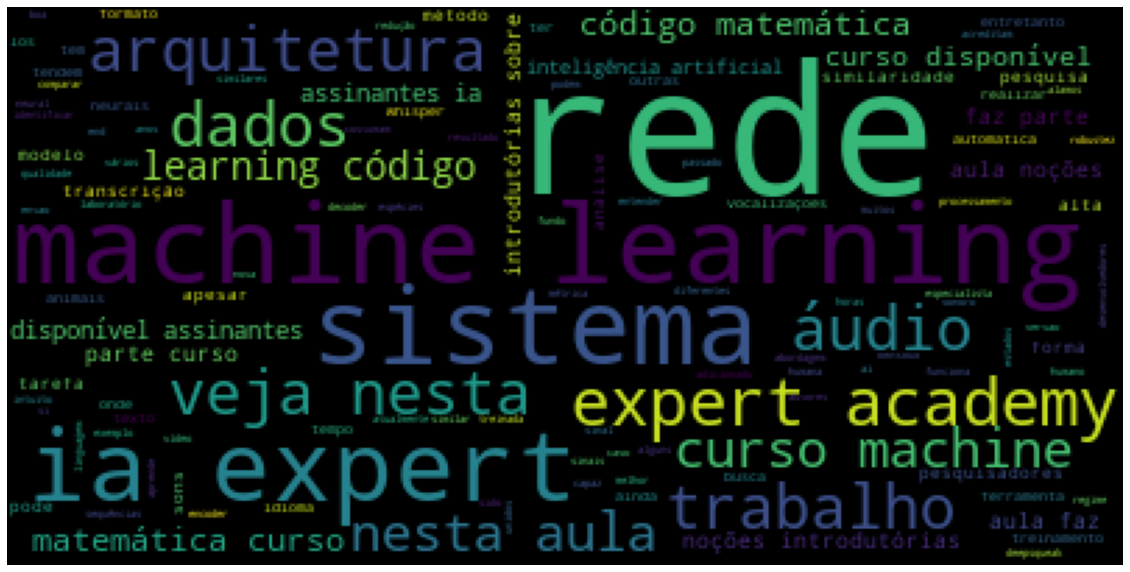

In [129]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
plt.axis('off')
plt.imshow(WordCloud().generate(conteudo_feed_formatado))

## Extração de entidades nomeadas

In [130]:
import spacy

In [131]:
!python -m spacy download pt_core_news_sm

2022-10-04 22:55:49.978851: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.0 MB 5.1 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


In [132]:
pln = spacy.load('pt_core_news_sm')

In [133]:
documento = pln(conteudo_feed_formatado)

In [135]:
from spacy import displacy
displacy.render(documento, style='ent', jupyter=True)

In [136]:
for entidade in documento.ents:
  if entidade.label_ == 'LOC':
    print(entidade.text, entidade.label_)

estados unidos LOC
washington LOC
